In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob

trainval = pd.read_csv('../data/caterpillar/train_set.csv')
test = pd.read_csv('../data/caterpillar/test_set.csv')

trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()

from sklearn.model_selection import train_test_split
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42
)

train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

train.shape, val.shape, test.shape

((22628, 8), (7585, 8), (30235, 8))

In [2]:
import numpy as np

materials = pd.read_csv('../data/caterpillar/bill_of_materials.csv')

materials_melted = pd.DataFrame(
    columns=['tube_assembly_id', 'component_id', 'quantity'])

for i in range(1, 9):
    component_id_i = 'component_id_' + str(i)
    quantity_i = 'quantity_' + str(i)
    materials_i = materials.melt(id_vars=['tube_assembly_id',
                                          component_id_i],
                                 value_vars=[quantity_i], 
                                 value_name='quantity').drop(
        columns='variable').rename(
        columns={component_id_i: 'component_id'})
    materials_melted = materials_melted.append(materials_i,
                                               ignore_index=True)    
    
materials = pd.pivot_table(materials_melted,
                           values='quantity',
                           columns='component_id',
                           index='tube_assembly_id'
                          ).reset_index().rename_axis('', axis='columns')

component_ids = list(materials.columns)[1:]

materials = materials.fillna(0)
counts = materials[component_ids].astype(int)
materials['Total'] = counts.sum(axis=1)
materials['Distinct'] = counts.gt(0).sum(axis=1)

large_count = counts.drop([col for col, val in counts.gt(0).sum().iteritems()
                      if val < 20], axis=1)

materials = pd.concat([materials['tube_assembly_id'],
                       large_count,
                       materials['Total'],
                       materials['Distinct']], axis=1)

materials

,tube_assembly_id,C-0001,C-0002,C-0003,C-0004,C-0007,C-0057,C-0071,C-0074,C-0095,...,C-2004,C-2005,C-2019,C-2027,C-2028,C-2029,C-2030,C-2032,Total,Distinct
0,TA-00001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
1,TA-00002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
2,TA-00003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
3,TA-00004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
4,TA-00005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
5,TA-00006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
6,TA-00007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
7,TA-00008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
8,TA-00009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
9,TA-00010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1


In [3]:
def wrangle(data):
    data = data.copy()
    
    # Engineer date features
    data['quote_date'] = pd.to_datetime(data['quote_date'], infer_datetime_format=True)
    data['quote_date_year'] = data['quote_date'].dt.year
    data['quote_date_month'] = data['quote_date'].dt.month
    data = data.drop(columns='quote_date')
    
    # Merge data
    tube = pd.read_csv('../data/caterpillar/tube.csv')
    specs = pd.read_csv('../data/caterpillar/specs.csv')
    data = data.merge(tube, how='left')
    data = data.merge(materials, how='left')
    data = data.merge(specs, how='left')

    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    data = data.drop(columns='tube_assembly_id')
    
    return data

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

print(train.shape, val.shape, test.shape)

(22628, 192) (7585, 192) (30235, 192)


In [4]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

target = 'cost'

X_train = train.drop(columns=target)
X_val = val.drop(columns=target)

y_train = train[target]
y_val = val[target]

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]

model = XGBRegressor(max_depth=7,
                 n_estimators=1000,
                 n_jobs=-1,
                 gamma=.05,
                 colsample_bytree=.3,
                 reg_alpha=.1,
                 reg_lambda=.95,
                 objective='reg:squarederror')
model.fit(X_train_encoded, np.array(y_train_log), 
          early_stopping_rounds=10, eval_metric='rmse', 
          eval_set=eval_set)

y_train_pred_log = model.predict(X_train_encoded)
y_val_pred_log = model.predict(X_val_encoded)

[0]	validation_0-rmse:1.72799	validation_1-rmse:1.71927
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.5841	validation_1-rmse:1.57882
[2]	validation_0-rmse:1.45741	validation_1-rmse:1.45294
[3]	validation_0-rmse:1.34581	validation_1-rmse:1.34284


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[4]	validation_0-rmse:1.2444	validation_1-rmse:1.2437
[5]	validation_0-rmse:1.15433	validation_1-rmse:1.15698
[6]	validation_0-rmse:1.05162	validation_1-rmse:1.05579
[7]	validation_0-rmse:0.959421	validation_1-rmse:0.965747
[8]	validation_0-rmse:0.879314	validation_1-rmse:0.887315
[9]	validation_0-rmse:0.824067	validation_1-rmse:0.83429
[10]	validation_0-rmse:0.77546	validation_1-rmse:0.787886
[11]	validation_0-rmse:0.734393	validation_1-rmse:0.749075
[12]	validation_0-rmse:0.695978	validation_1-rmse:0.713098
[13]	validation_0-rmse:0.641811	validation_1-rmse:0.660909
[14]	validation_0-rmse:0.613222	validation_1-rmse:0.634239
[15]	validation_0-rmse:0.58852	validation_1-rmse:0.611677
[16]	validation_0-rmse:0.567223	validation_1-rmse:0.591243
[17]	validation_0-rmse:0.549672	validation_1-rmse:0.574707
[18]	validation_0-rmse:0.534037	validation_1-rmse:0.559815
[19]	validation_0-rmse:0.519378	validation_1-rmse:0.546836
[20]	validation_0-rmse:0.483193	validation_1-rmse:0.512501
[21]	validatio

[143]	validation_0-rmse:0.166514	validation_1-rmse:0.268242
[144]	validation_0-rmse:0.166022	validation_1-rmse:0.267987
[145]	validation_0-rmse:0.165972	validation_1-rmse:0.267976
[146]	validation_0-rmse:0.165825	validation_1-rmse:0.267954
[147]	validation_0-rmse:0.165684	validation_1-rmse:0.267899
[148]	validation_0-rmse:0.164949	validation_1-rmse:0.267642
[149]	validation_0-rmse:0.164424	validation_1-rmse:0.267201
[150]	validation_0-rmse:0.164286	validation_1-rmse:0.267113
[151]	validation_0-rmse:0.163687	validation_1-rmse:0.267087
[152]	validation_0-rmse:0.163112	validation_1-rmse:0.266668
[153]	validation_0-rmse:0.162687	validation_1-rmse:0.26648
[154]	validation_0-rmse:0.162534	validation_1-rmse:0.266424
[155]	validation_0-rmse:0.16206	validation_1-rmse:0.266074
[156]	validation_0-rmse:0.16165	validation_1-rmse:0.266066
[157]	validation_0-rmse:0.161588	validation_1-rmse:0.266042
[158]	validation_0-rmse:0.160748	validation_1-rmse:0.265612
[159]	validation_0-rmse:0.160709	validation

[281]	validation_0-rmse:0.137845	validation_1-rmse:0.258564
[282]	validation_0-rmse:0.137662	validation_1-rmse:0.258495
[283]	validation_0-rmse:0.137588	validation_1-rmse:0.258458
[284]	validation_0-rmse:0.13757	validation_1-rmse:0.258437
[285]	validation_0-rmse:0.137518	validation_1-rmse:0.258434
[286]	validation_0-rmse:0.137495	validation_1-rmse:0.258427
[287]	validation_0-rmse:0.137399	validation_1-rmse:0.258401
[288]	validation_0-rmse:0.136744	validation_1-rmse:0.257823
[289]	validation_0-rmse:0.136725	validation_1-rmse:0.257808
[290]	validation_0-rmse:0.136378	validation_1-rmse:0.257759
[291]	validation_0-rmse:0.136274	validation_1-rmse:0.257743
[292]	validation_0-rmse:0.136117	validation_1-rmse:0.257721
[293]	validation_0-rmse:0.136091	validation_1-rmse:0.257712
[294]	validation_0-rmse:0.13604	validation_1-rmse:0.257707
[295]	validation_0-rmse:0.13602	validation_1-rmse:0.257688
[296]	validation_0-rmse:0.136002	validation_1-rmse:0.257684
[297]	validation_0-rmse:0.13592	validation_

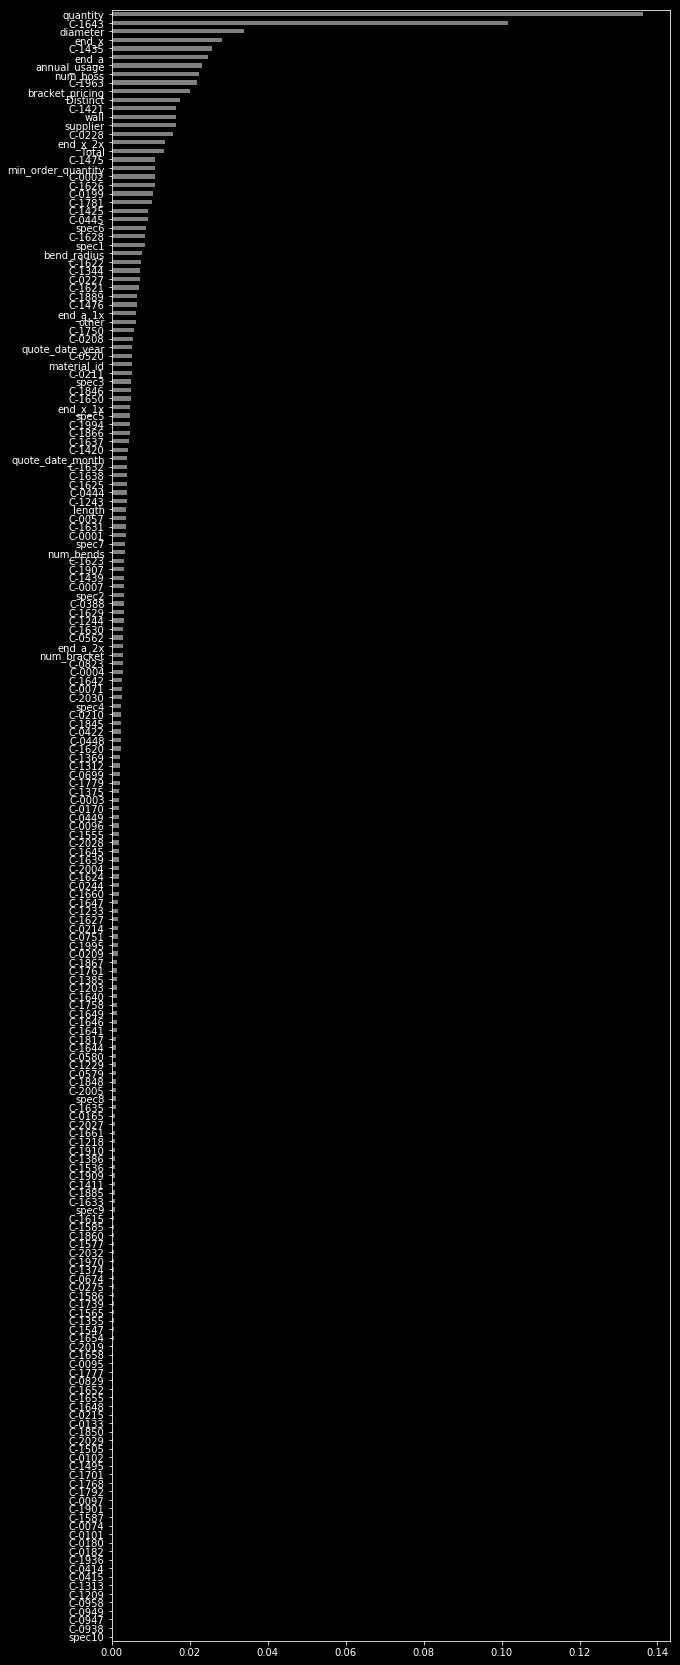

In [6]:
coefficients = pd.Series(model.feature_importances_,
                         X_train.columns.tolist())
plt.style.use('dark_background')
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');
plt.show()

In [7]:
column = 'quantity'

score_with = rmse(y_val_log, y_val_pred_log)

eval_set = [(X_train_encoded.drop(columns=column), y_train_log), 
            (X_val_encoded.drop(columns=column), y_val_log)]

model.fit(X_train_encoded.drop(columns=column), np.array(y_train_log), 
          early_stopping_rounds=10, eval_metric='rmse', 
          eval_set=eval_set)

y_val_pred_log = model.predict(X_val_encoded.drop(columns=column))
score_without = rmse(y_val_log, y_val_pred_log)

print(f'Validation RMSLE with {column}:', score_with)
print(f'Validation RMSLE without {column}:', score_without)
print(f'Drop-Column Importance for {column}:', score_without - score_with)

[0]	validation_0-rmse:1.73453	validation_1-rmse:1.72243
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.59234	validation_1-rmse:1.58339
[2]	validation_0-rmse:1.46176	validation_1-rmse:1.4559
[3]	validation_0-rmse:1.34669	validation_1-rmse:1.34366


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[4]	validation_0-rmse:1.24871	validation_1-rmse:1.2463
[5]	validation_0-rmse:1.15919	validation_1-rmse:1.15922
[6]	validation_0-rmse:1.0839	validation_1-rmse:1.08594
[7]	validation_0-rmse:1.01567	validation_1-rmse:1.02046
[8]	validation_0-rmse:0.956187	validation_1-rmse:0.96284
[9]	validation_0-rmse:0.902225	validation_1-rmse:0.912275
[10]	validation_0-rmse:0.861178	validation_1-rmse:0.87282
[11]	validation_0-rmse:0.822275	validation_1-rmse:0.835608
[12]	validation_0-rmse:0.789863	validation_1-rmse:0.804844
[13]	validation_0-rmse:0.762148	validation_1-rmse:0.778594
[14]	validation_0-rmse:0.740167	validation_1-rmse:0.757186
[15]	validation_0-rmse:0.719809	validation_1-rmse:0.738446
[16]	validation_0-rmse:0.70307	validation_1-rmse:0.723168
[17]	validation_0-rmse:0.688438	validation_1-rmse:0.709838
[18]	validation_0-rmse:0.675037	validation_1-rmse:0.697987
[19]	validation_0-rmse:0.662158	validation_1-rmse:0.686488
[20]	validation_0-rmse:0.651621	validation_1-rmse:0.677249
[21]	validation_

[143]	validation_0-rmse:0.55924	validation_1-rmse:0.606632
[144]	validation_0-rmse:0.559201	validation_1-rmse:0.606604
[145]	validation_0-rmse:0.55915	validation_1-rmse:0.606534
[146]	validation_0-rmse:0.559056	validation_1-rmse:0.606511
[147]	validation_0-rmse:0.558905	validation_1-rmse:0.60645
[148]	validation_0-rmse:0.558891	validation_1-rmse:0.606433
[149]	validation_0-rmse:0.558765	validation_1-rmse:0.606378
[150]	validation_0-rmse:0.558631	validation_1-rmse:0.606212
[151]	validation_0-rmse:0.558515	validation_1-rmse:0.606183
[152]	validation_0-rmse:0.558423	validation_1-rmse:0.606166
[153]	validation_0-rmse:0.558368	validation_1-rmse:0.606162
[154]	validation_0-rmse:0.558317	validation_1-rmse:0.606037
[155]	validation_0-rmse:0.558189	validation_1-rmse:0.605967
[156]	validation_0-rmse:0.558101	validation_1-rmse:0.605889
[157]	validation_0-rmse:0.55805	validation_1-rmse:0.605867
[158]	validation_0-rmse:0.557992	validation_1-rmse:0.605857
[159]	validation_0-rmse:0.557952	validation_

[281]	validation_0-rmse:0.551209	validation_1-rmse:0.602763
[282]	validation_0-rmse:0.551181	validation_1-rmse:0.602728
[283]	validation_0-rmse:0.551172	validation_1-rmse:0.602723
[284]	validation_0-rmse:0.55113	validation_1-rmse:0.602726
[285]	validation_0-rmse:0.551115	validation_1-rmse:0.602736
[286]	validation_0-rmse:0.551095	validation_1-rmse:0.602697
[287]	validation_0-rmse:0.551069	validation_1-rmse:0.602673
[288]	validation_0-rmse:0.551069	validation_1-rmse:0.602673
[289]	validation_0-rmse:0.551056	validation_1-rmse:0.602666
[290]	validation_0-rmse:0.551043	validation_1-rmse:0.602651
[291]	validation_0-rmse:0.550996	validation_1-rmse:0.602627
[292]	validation_0-rmse:0.55095	validation_1-rmse:0.60261
[293]	validation_0-rmse:0.55093	validation_1-rmse:0.602628
[294]	validation_0-rmse:0.550919	validation_1-rmse:0.602619
[295]	validation_0-rmse:0.550902	validation_1-rmse:0.602605
[296]	validation_0-rmse:0.550894	validation_1-rmse:0.602604
[297]	validation_0-rmse:0.550889	validation_

[418]	validation_0-rmse:0.547445	validation_1-rmse:0.601271
[419]	validation_0-rmse:0.547441	validation_1-rmse:0.601261
[420]	validation_0-rmse:0.547441	validation_1-rmse:0.601261
[421]	validation_0-rmse:0.54743	validation_1-rmse:0.601263
[422]	validation_0-rmse:0.547393	validation_1-rmse:0.601259
[423]	validation_0-rmse:0.547385	validation_1-rmse:0.601252
[424]	validation_0-rmse:0.54734	validation_1-rmse:0.601244
[425]	validation_0-rmse:0.547327	validation_1-rmse:0.601222
[426]	validation_0-rmse:0.547303	validation_1-rmse:0.601222
[427]	validation_0-rmse:0.547278	validation_1-rmse:0.601212
[428]	validation_0-rmse:0.547278	validation_1-rmse:0.601212
[429]	validation_0-rmse:0.547272	validation_1-rmse:0.601212
[430]	validation_0-rmse:0.547272	validation_1-rmse:0.601212
[431]	validation_0-rmse:0.547265	validation_1-rmse:0.60121
[432]	validation_0-rmse:0.547264	validation_1-rmse:0.60121
[433]	validation_0-rmse:0.547251	validation_1-rmse:0.601204
[434]	validation_0-rmse:0.54723	validation_1

In [8]:
import eli5
from eli5.sklearn import PermutationImportance

X_train_encoded = X_train_encoded.fillna(X_train_encoded.mean())
X_val_encoded = X_val_encoded.fillna(X_val_encoded.mean())

eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]

model.fit(X_train_encoded, np.array(y_train_log), 
          early_stopping_rounds=10, eval_metric='rmse', 
          eval_set=eval_set)

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_val_encoded, y_val_log)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

[0]	validation_0-rmse:1.72798	validation_1-rmse:1.71892
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.58411	validation_1-rmse:1.57844
[2]	validation_0-rmse:1.45755	validation_1-rmse:1.45284
[3]	validation_0-rmse:1.34598	validation_1-rmse:1.34274


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[4]	validation_0-rmse:1.24463	validation_1-rmse:1.24316
[5]	validation_0-rmse:1.1545	validation_1-rmse:1.15624
[6]	validation_0-rmse:1.05177	validation_1-rmse:1.05511
[7]	validation_0-rmse:0.959558	validation_1-rmse:0.965072
[8]	validation_0-rmse:0.879483	validation_1-rmse:0.886609
[9]	validation_0-rmse:0.824205	validation_1-rmse:0.833553
[10]	validation_0-rmse:0.775516	validation_1-rmse:0.787236
[11]	validation_0-rmse:0.734462	validation_1-rmse:0.748177
[12]	validation_0-rmse:0.696038	validation_1-rmse:0.712083
[13]	validation_0-rmse:0.642065	validation_1-rmse:0.660143
[14]	validation_0-rmse:0.613448	validation_1-rmse:0.633416
[15]	validation_0-rmse:0.588838	validation_1-rmse:0.610618
[16]	validation_0-rmse:0.567446	validation_1-rmse:0.590222
[17]	validation_0-rmse:0.549798	validation_1-rmse:0.573667
[18]	validation_0-rmse:0.534229	validation_1-rmse:0.558938
[19]	validation_0-rmse:0.519839	validation_1-rmse:0.546182
[20]	validation_0-rmse:0.48361	validation_1-rmse:0.511752
[21]	valida

[143]	validation_0-rmse:0.166367	validation_1-rmse:0.266
[144]	validation_0-rmse:0.166088	validation_1-rmse:0.265809
[145]	validation_0-rmse:0.166028	validation_1-rmse:0.265818
[146]	validation_0-rmse:0.16569	validation_1-rmse:0.265729
[147]	validation_0-rmse:0.165518	validation_1-rmse:0.265653
[148]	validation_0-rmse:0.165296	validation_1-rmse:0.265526
[149]	validation_0-rmse:0.16503	validation_1-rmse:0.265401
[150]	validation_0-rmse:0.164731	validation_1-rmse:0.265227
[151]	validation_0-rmse:0.164267	validation_1-rmse:0.265064
[152]	validation_0-rmse:0.163674	validation_1-rmse:0.264583
[153]	validation_0-rmse:0.163617	validation_1-rmse:0.264579
[154]	validation_0-rmse:0.163425	validation_1-rmse:0.264452
[155]	validation_0-rmse:0.163254	validation_1-rmse:0.264296
[156]	validation_0-rmse:0.162923	validation_1-rmse:0.264242
[157]	validation_0-rmse:0.162512	validation_1-rmse:0.264248
[158]	validation_0-rmse:0.161917	validation_1-rmse:0.263783
[159]	validation_0-rmse:0.161812	validation_1

[281]	validation_0-rmse:0.138947	validation_1-rmse:0.255573
[282]	validation_0-rmse:0.138609	validation_1-rmse:0.255435
[283]	validation_0-rmse:0.13851	validation_1-rmse:0.255415
[284]	validation_0-rmse:0.13849	validation_1-rmse:0.255414
[285]	validation_0-rmse:0.13838	validation_1-rmse:0.255453
[286]	validation_0-rmse:0.138262	validation_1-rmse:0.255403
[287]	validation_0-rmse:0.138054	validation_1-rmse:0.25524
[288]	validation_0-rmse:0.137618	validation_1-rmse:0.254835
[289]	validation_0-rmse:0.137605	validation_1-rmse:0.254837
[290]	validation_0-rmse:0.137523	validation_1-rmse:0.254818
[291]	validation_0-rmse:0.137444	validation_1-rmse:0.254795
[292]	validation_0-rmse:0.137383	validation_1-rmse:0.254777
[293]	validation_0-rmse:0.13735	validation_1-rmse:0.254689
[294]	validation_0-rmse:0.137304	validation_1-rmse:0.254705
[295]	validation_0-rmse:0.137066	validation_1-rmse:0.254588
[296]	validation_0-rmse:0.136916	validation_1-rmse:0.254535
[297]	validation_0-rmse:0.136903	validation_1

Weight,Feature
0.6902 ± 0.0059,quantity
0.0863 ± 0.0014,min_order_quantity
0.0768 ± 0.0010,annual_usage
0.0607 ± 0.0004,diameter
0.0481 ± 0.0026,supplier
0.0203 ± 0.0007,Distinct
0.0187 ± 0.0002,length
0.0140 ± 0.0003,wall
0.0139 ± 0.0014,quote_date_year
0.0131 ± 0.0005,end_x


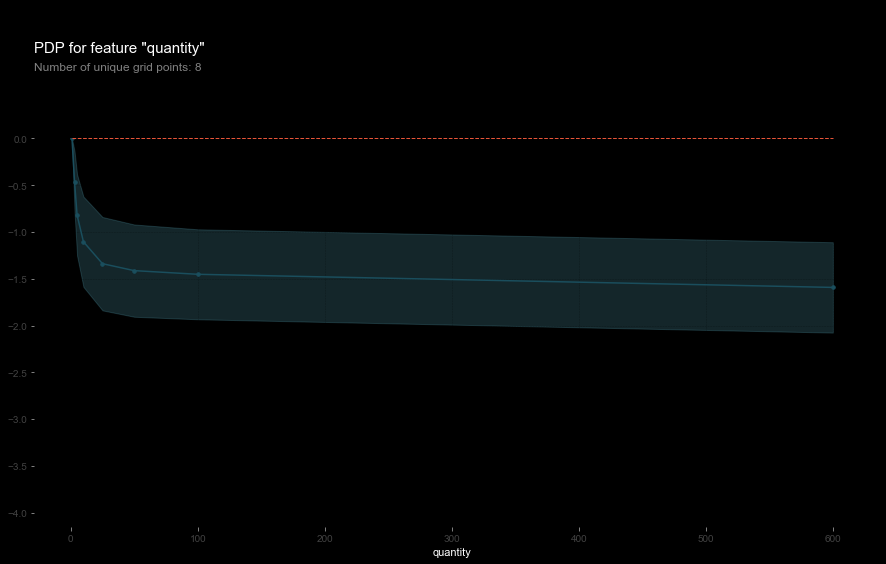

In [10]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'quantity'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

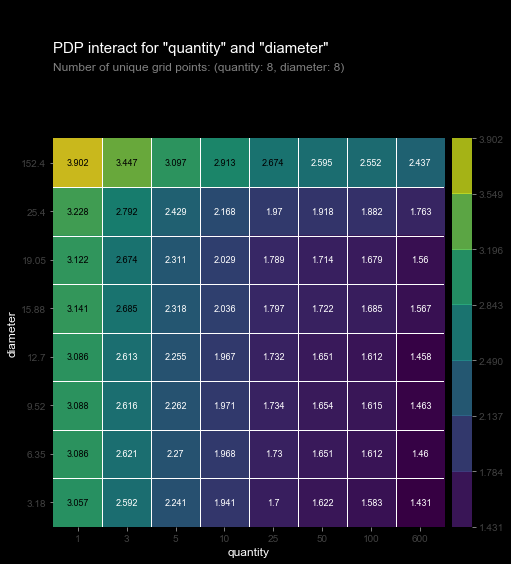

In [11]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['quantity', 'diameter']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);